In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 is installed.")
except:
    print("Modul mpld3 is NOT installed.")

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots signal in Time domain. """
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    """ Function that plots signal in Frequency domain. """
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

# def plot_sonar(x, fs, c, slope, title="", show=True, **kwargs):
#     n = len(x)
#     F = np.fft.fftfreq(n)
#     dist = F * fs * c / 2 / slope
#     dist = dist[:n//2]
#     X = abs(np.fft.fft(x))[:n//2]
#     X_dB = 20 * np.log10(X)
#     X_dB -= np.max(X_dB)
#     # Threshold value
#     th = -10
#     # Find peaks above the threshold
#     peaks, _ = signal.find_peaks(X_dB, height=th)
#     # Convert indices to distances 
#     distance_peaks = np.array(peaks) / n * fs * c / 2 / slope

#     # fig = plt.figure(figsize=(6, 4))
#     plt.plot(dist, X_dB)
#     plt.plot(distance_peaks, X_dB[peaks], "x")
#     # Annotate each peak with its distance
#     for i, peak in enumerate(distance_peaks):
#         plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
#     plt.xlabel("Distance [m]")
#     plt.ylabel("|X| dB")
#     # plt.title(title if title else f"Spectrum of TX and RX channel product, fs = {round(fs / D / 1e3)} kHz")
#     plt.title(title)
#     plt.ylim([min(X_dB), 10])
    
#     if show:
#         plt.show()

def plot_sonar(x, fs, c, slope, title="", show=True, **kwargs):
    n = len(x)
    F = np.fft.fftfreq(n)
    dist = F * fs * c / 2 / slope
    dist = dist[:n // 2]
    X = abs(np.fft.fft(x))[:n // 2]
    X_dB = 20 * np.log10(X)
    X_dB -= np.max(X_dB)
    th = -10
    peaks, _ = signal.find_peaks(X_dB, height=th)
    distance_peaks = np.array(peaks) / n * fs * c / 2 / slope
    plt.plot(dist, X_dB)
    plt.plot(distance_peaks, X_dB[peaks], "x")
    for i, peak in enumerate(distance_peaks):
        plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
    plt.xlabel("Distance [m]")
    plt.ylabel("|X| dB")
    plt.title(title)
    plt.ylim([min(X_dB), 10])
    if show:
        plt.show()

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots FIR impulse response in dB. """
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that stems FIR's coeffitients. """
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    """ Function that generates FIR coeffitients based on number of coeffitients and transititon zone. """
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True):
    """ Function that generates FIR coeffitients based on ripple in pass band and attenuation in non-passed band. """
    num_taps = n_FIR
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    if not symetric:
        fir_freqs[2] = 1 / (2 * D)
        
    while(True):
        fir_coeff = signal.firls(num_taps, fir_freqs, fir_response, fs = 1)
        w, h = signal.freqz(fir_coeff)
        H = 20 * np.log10(abs(h))
        ripple_ = np.max(H[:int(len(H) * 2*fir_freqs[1])]) - np.min(H[:int(len(H) * 2*fir_freqs[1])])
        attenuation_ = np.max(H[int(len(H) * 2*fir_freqs[2]):])
        if(ripple_ <= ripple and -attenuation_ >= attenuation):
            break
        else:
            num_taps += 2
    return fir_coeff

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)
    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain


Modul mpld3 is installed.


## <center> Test signal and FIR coeffitients

In [2]:
D = 2
# Generate Test signal
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1]
x = 2*gen_test_spectrum(n, f, a, False).real

# Generate FIR Coefficient
# n_FIR = 1
# ripple = 1e-3
# attenuation = 90 # in dB
transition_width = 0.05
h = gen_FIR(11, D, transition_width)
# fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)

## <center> Decimation of Test Signal in __Floating-Point__ Arithmetic

In [3]:
def make_polyphase_coeff(coeff, M):
    """ Function that generates polyphase coeffitients out of FIR coeffititents. """
    n = int(np.ceil(len(coeff) / M))
    tmp = np.zeros(M * n)
    tmp[:len(coeff)] = coeff
    poly_coeff = np.zeros((M, n))
    for m in range(M):
        poly_coeff[m, :] = tmp[m::M]
    return poly_coeff

def fir_direct(x, coeff, state = None):
    if state == None:
        delay_line = np.zeros(len(x))
    else:
        delay_line = state
    y = np.zeros(len(x))
    for n in range(len(x)):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]
        for m in range(len(coeff)):
            y[n] += coeff[m] * delay_line[m]
    return y

def decimate_polyphase(x, coeff, D):
    poly_coeff = make_polyphase_coeff(coeff, D)
    x_periodic = np.concatenate((x, x[:len(coeff)-1]))
    y = 0
    for d in range(D):
        fir_in = x_periodic[d::D]
        tmp = fir_direct(fir_in, poly_coeff[D-1-d])
        # tmp = signal.lfilter(poly_coeff[D-1-d], 1, fir_in)
        # tmp = tmp[int(len(coeff)/D):]
        y += tmp
    y = y[int(len(coeff)/D):]
    return y

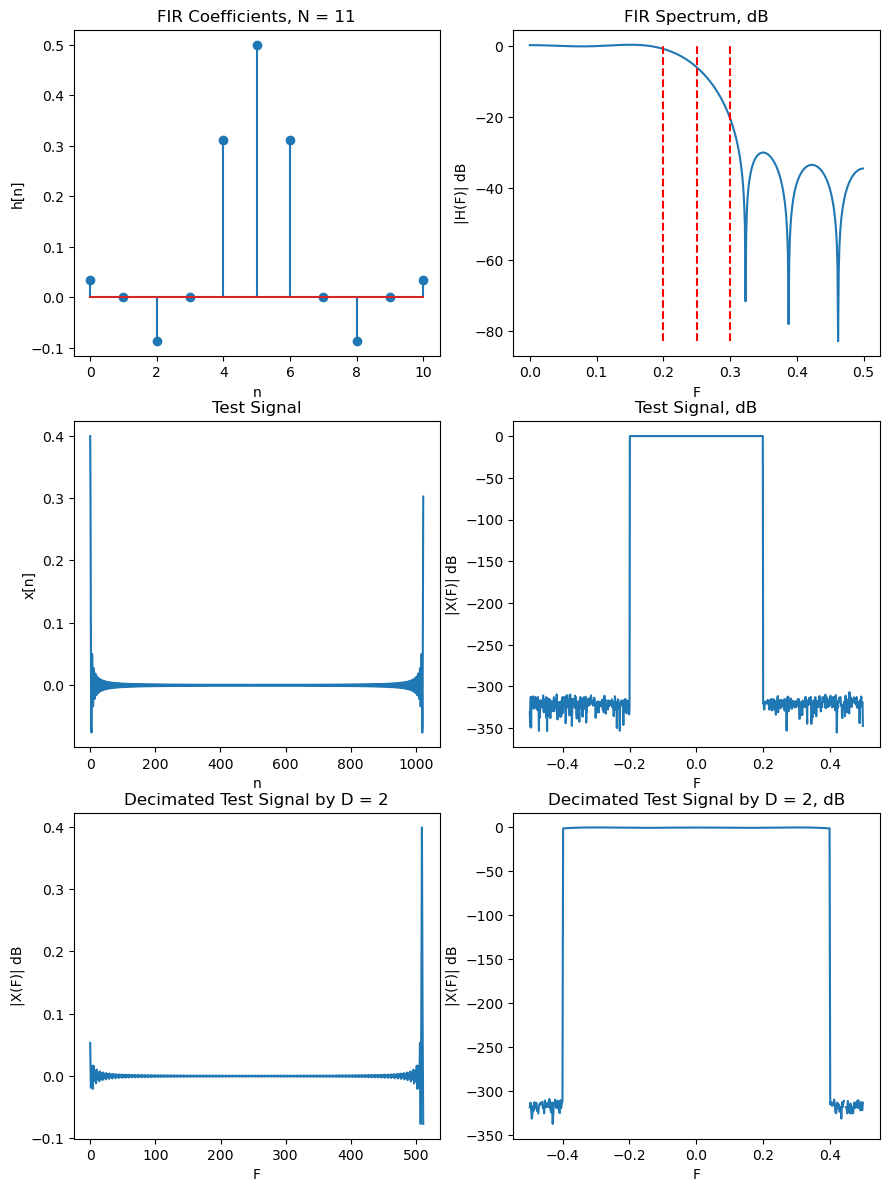

In [4]:
# Perform decimation by D
x_decimated = decimate_polyphase(x, h, D)

# Plot results
figH = 4
ax_x = 3; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 3.6 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(h, 'n', 'h[n]', f"FIR Coefficients, N = {len(h)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(h, 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)
plt.subplot(ax_x, ax_y, 3)
plot_signal(x, 'n', 'x[n]', "Test Signal", show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x, 'F', '|X(F)| dB', "Test Signal, dB", show = False)
plt.subplot(ax_x, ax_y, 5)
plot_signal(x_decimated, 'F', '|X(F)| dB', f"Decimated Test Signal by D = {D}", show = False)
plt.subplot(ax_x, ax_y, 6)
plot_spectrum(x_decimated, 'F', '|X(F)| dB',  f"Decimated Test Signal by D = {D}, dB", show = False)

## <center> Decimation of Sonar Signal in ___Floating-Point___ Arithmetic

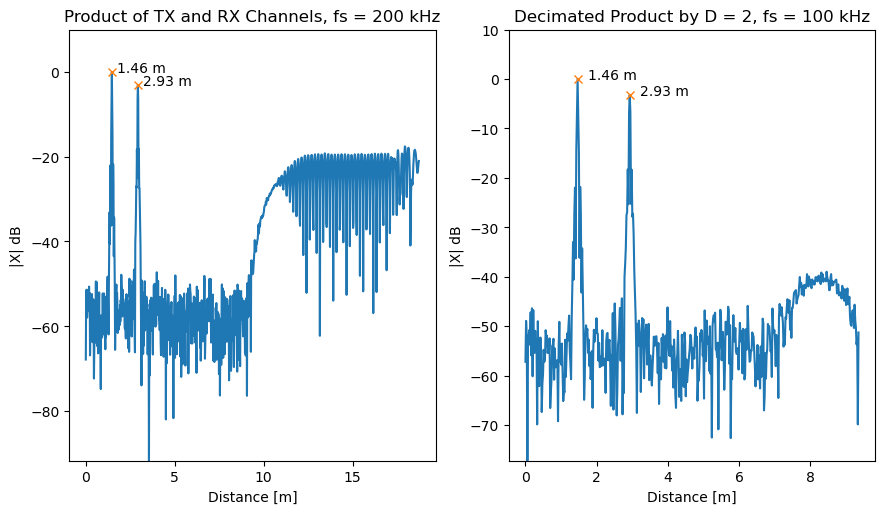

In [5]:
import pprint
import scipy.io

file_path = r"..\sonar_signals.mat"
# Load the .mat file
mat_data = scipy.io.loadmat(file_path)
rx_chirp = np.array(mat_data['rxChirp'])[0]
tx_chirp = np.array(mat_data['txChirp'])[0]
# Product of RX and TX channels (output of mixer)
product = rx_chirp * tx_chirp

time = 0.01       # In seconds
c = 1500          # In m/s
fs = 200e3        # In Hz
f_start = 20e3    # In Hz
f_end = 60e3      # In Hz
slope = (f_end - f_start) / time

# Decimation of product
product_decimated = decimate_polyphase(product, h, D)

# Plot results
figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1.4 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_sonar(product, fs, c, slope, title=f"Product of TX and RX Channels, fs = {int(fs/1e3)} kHz", show=False)
plt.subplot(ax_x, ax_y, 2)
plot_sonar(product_decimated, fs/D, c, slope, title=f"Decimated Product by D = {D}, fs = {int(fs/D/1e3)} kHz", show=False)

## <center> Decimation of Test Signal in __Fixed-Point__ Arithmetic

In [6]:
from fxpmath import Fxp

def fir_direct_fxp(x, h, state = None, full_precision = False):
    N = len(x)
    M = len(h)
    delay_line = np.zeros(M) if state is None else state
    y_ = []
    
    for n in range(N):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n].get_val()
        acc = Fxp(0, signed=x.signed, n_word=x.n_word + h.n_word, n_frac=x.n_frac + h.n_frac)
        acc.rounding, acc.overflow = x.rounding, x.overflow
        for m in range(M):
            acc = Fxp(acc.get_val() + delay_line[m] * h[m].get_val(), like = acc)
        y_.append(acc.get_val())

    if full_precision:
        y = Fxp(y_, signed=x.signed, n_word=x.n_word + h.n_word, n_frac=x.n_frac + h.n_frac)
    else:
        y = Fxp(y_, signed=x.signed, n_word=x.n_word, n_frac=x.n_frac)
    y.rounding, y.overflow = x.rounding, x.overflow
    return y

def decimation_polyphase_fxp(x, h, D, full_precision = False):
    y_ = Fxp(np.zeros(len(x)//D), signed=x.signed, n_word=x.n_word + h.n_word, n_frac=x.n_frac + h.n_frac)
    y_.rounding, y_.overflow = x.rounding, x.overflow

    for d in range(D):
        fir_in = x[d::D]
        tmp = fir_direct_fxp(fir_in, h[D-1-d], full_precision = True)
        y_ += tmp

    if full_precision:
        y = Fxp(y_.get_val(), signed=x.signed, n_word=x.n_word + h.n_word, n_frac=x.n_frac + h.n_frac)
    else:
        y = Fxp(y_.get_val(), signed=x.signed, n_word=x.n_word, n_frac=x.n_frac)
    y.rounding, y.overflow = x.rounding, x.overflow
    return y
    

In [7]:
# Concatenate input array with the first len(h)-1 elements
x_per = np.concatenate((x, x[:len(h)-1]))
h_poly = make_polyphase_coeff(h, D)

# Overflow method can be 'saturate' or 'wrap'
overflow_method = 'wrap'
# Rounding method can be 'floor', 'trunc', 'around', 'ceil', 'fix'
rounding_method = 'trunc'
n_word = 16
n_frac = 15

# Create a template Fxp object
template_fxp = Fxp(0, signed=True, n_word=n_word, n_frac=n_frac, overflow=overflow_method, rounding=rounding_method)

# Create Fxp objects for input arrays and coefficients
x_fxp = Fxp(x, like=template_fxp)
x_fxp.rounding = rounding_method
x_fxp.overflow = overflow_method

x_per_fxp = Fxp(x_per, like=template_fxp)
x_per_fxp.rounding = rounding_method
x_per_fxp.overflow = overflow_method

h_fxp = Fxp(h, like=template_fxp)
h_fxp.rounding = rounding_method
h_fxp.overflow = overflow_method

h_poly_fxp = Fxp(h_poly, like=template_fxp)
h_poly_fxp.rounding = rounding_method
h_poly_fxp.overflow = overflow_method

# Perform decimation
x_decimated_fxp = decimation_polyphase_fxp(x_per_fxp, h_poly_fxp, D, full_precision=True)
x_decimated_fxp = x_decimated_fxp[len(h)//D:]
# x_decimated_fxp = polyphase_decimate_fir_direct_transposed_fxp(x_per_fxp, h_fxp, D, outFxpFormat="fxp")


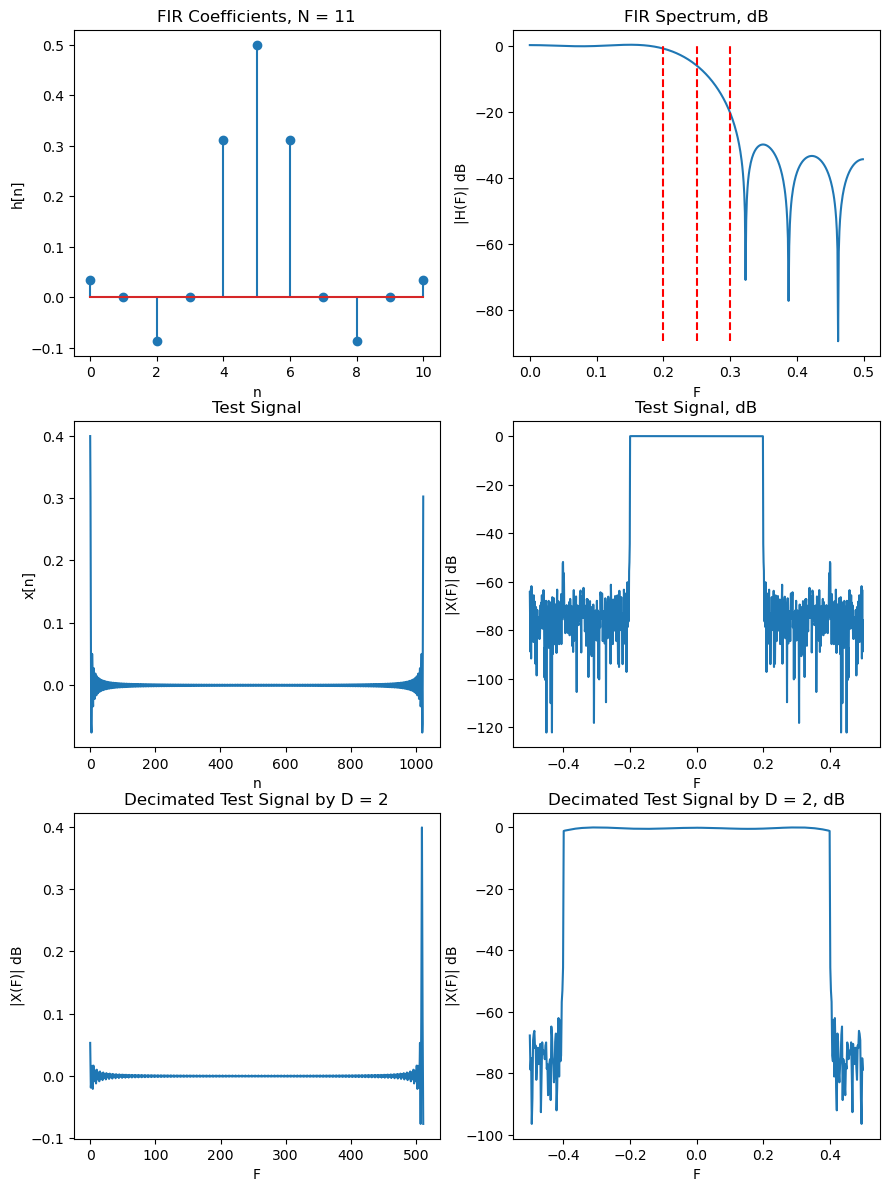

In [8]:
figH = 4
ax_x = 3; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 3.6 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(h_fxp(), 'n', 'h[n]', f"FIR Coefficients, N = {len(h)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(h_fxp(), 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)
plt.subplot(ax_x, ax_y, 3)
plot_signal(x_fxp(), 'n', 'x[n]', "Test Signal", show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x_fxp(), 'F', '|X(F)| dB', "Test Signal, dB", show = False)
plt.subplot(ax_x, ax_y, 5)
plot_signal(x_decimated_fxp(), 'F', '|X(F)| dB', f"Decimated Test Signal by D = {D}", show = False)
plt.subplot(ax_x, ax_y, 6)
plot_spectrum(x_decimated_fxp(), 'F', '|X(F)| dB',  f"Decimated Test Signal by D = {D}, dB", show = False)

### Writing test signal and FIR coeffitients to file for VHDL code.

In [9]:
import numpy as np
from fxpmath import Fxp

def write_to_file(x, file):
    with open(file, 'w') as f:
        for i in range(len(x)):
            if i < len(x) - 1:
                f.write(str(x[i]) + '\n')
            else:
                f.write(str(x[i]))

def write_to_file_(x, file):
    with open(file, 'w') as f:
        for i in range(len(x)):
            if i < len(x) - 1:
                f.write("x\"" + str(x[i][2:]) + "\",\n")
            else:
                f.write("x\"" + str(x[i][2:]) + "\"")

# Example usage
test_file = r'..\test_signal.txt'
coeff_file = r'..\fir_coeff.txt'
result_file = r'..\fir_test_signal.txt'

# Ensure the values are stored as they are in memory (hex representation)
write_to_file(x_per_fxp.val, test_file)
write_to_file_(h_fxp.hex(), coeff_file)

print("Polyphase FIR decomposition:")
print(h_poly_fxp.val)


Polyphase FIR decomposition:
[[ 1144 -2851 10211 10211 -2851  1144]
 [    0     0 16383     0     0     0]]


## <center> Decimation of Sonar Signal in ___Fixed-Point___ Arithmetic

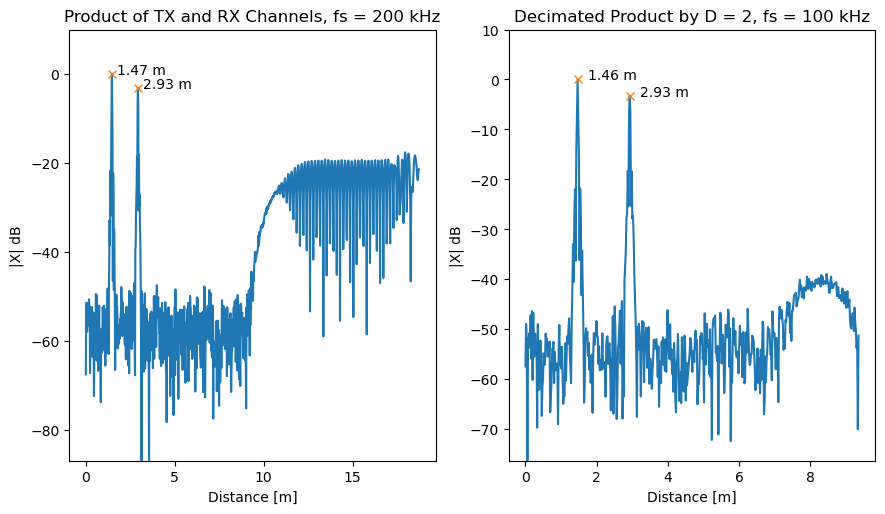

In [10]:
import pprint
import scipy.io

# Load the .mat file
file_path = r"..\sonar_signals.mat"
mat_data = scipy.io.loadmat(file_path)
rx_chirp = np.array(mat_data['rxChirp'])[0]
tx_chirp = np.array(mat_data['txChirp'])[0]

# Product of RX and TX channels (output of mixer)
product = rx_chirp * tx_chirp
product /= np.max(product)*2
product_per = np.concatenate((product, product[:len(h)-1]))

time = 0.01       # In seconds
c = 1500          # In m/s
fs = 200e3        # In Hz
f_start = 20e3    # In Hz
f_end = 60e3      # In Hz
slope = (f_end - f_start) / time

# Create Fxp object for the product
product_Fxp = Fxp(product_per, like=x_fxp)
product_Fxp.overflow, product_Fxp.rounding = x_fxp.overflow, x_fxp.rounding

# Decimation of product
product_decimated_Fxp = decimation_polyphase_fxp(product_Fxp, h_poly_fxp, D, full_precision=False)
product_decimated_Fxp = product_decimated_Fxp[len(h)//D:]
product_decimated_Fxp = product_decimated_Fxp.get_val()

# Plot results
figH = 4
ax_x = 1
ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1.4 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_sonar(product_Fxp[len(h):].get_val(), fs, c, slope, title=f"Product of TX and RX Channels, fs = {int(fs/1e3)} kHz", show=False)
plt.subplot(ax_x, ax_y, 2)
plot_sonar(product_decimated_Fxp, fs/D, c, slope, title=f"Decimated Product by D = {D}, fs = {int(fs/D/1e3)} kHz", show=False)